In [2]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Make plots a bit larger
plt.rcParams["figure.figsize"] = (10, 5)

# Connect to the DuckDB warehouse
con = duckdb.connect("../warehouse/edtech_engagement.duckdb")

con

In [3]:
con.execute("""
    SELECT table_schema, table_name
    FROM information_schema.tables
    WHERE table_schema = 'analytics'
    ORDER BY table_name;
""").df()

,table_schema,table_name
0,analytics,fct_daily_engagement
1,analytics,my_first_dbt_model
2,analytics,my_second_dbt_model
3,analytics,stg_districts
4,analytics,stg_engagement
5,analytics,stg_products


In [5]:
fct_sample = con.execute("""
    SELECT *
    FROM analytics.fct_daily_engagement
    LIMIT 10;
""").df()

fct_sample

,lp_id,usage_date,avg_pct_access,avg_engagement_index
0,91165,2020-05-21,0.444407,49.771333
1,92844,2020-05-25,0.049895,9.686277
2,61441,2020-06-09,1.616782,253.212143
3,86059,2020-06-11,0.109420,12.041404
4,55450,2020-06-17,0.329756,87.695734
5,61292,2020-06-18,3.656190,1764.997892
6,45328,2020-07-03,0.048462,15.152500
7,10450,2020-07-10,0.014615,0.661000
8,10450,2020-07-17,0.020714,2.874545
9,33185,2020-08-12,1.088458,225.822857


In [6]:
engagement_stats = con.execute("""
    SELECT
        MIN(avg_engagement_index) AS min_engagement,
        AVG(avg_engagement_index) AS avg_engagement,
        MAX(avg_engagement_index) AS max_engagement
    FROM analytics.fct_daily_engagement;
""").df()

engagement_stats

,min_engagement,avg_engagement,max_engagement
0,0.01,28.006154,30119.935667


In [7]:
trend = con.execute("""
    SELECT
        usage_date,
        AVG(avg_engagement_index) AS avg_engagement
    FROM analytics.fct_daily_engagement
    GROUP BY usage_date
    ORDER BY usage_date
""").df()

trend.head()

,usage_date,avg_engagement
0,2020-01-01,5.078011
1,2020-01-02,22.495558
2,2020-01-03,22.429033
3,2020-01-04,5.605395
4,2020-01-05,6.649474


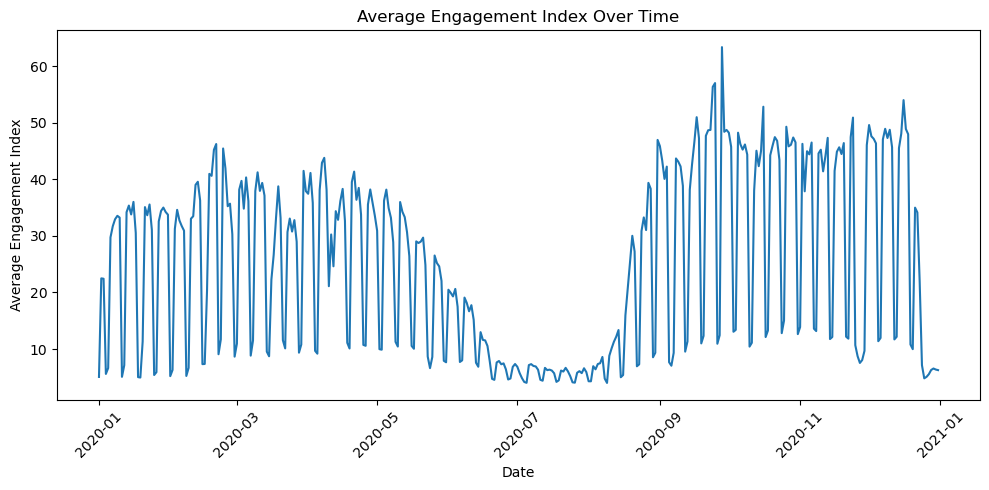

In [8]:
plt.plot(trend["usage_date"], trend["avg_engagement"])
plt.title("Average Engagement Index Over Time")
plt.xlabel("Date")
plt.ylabel("Average Engagement Index")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
top_products = con.execute("""
    SELECT
        lp_id,
        AVG(avg_engagement_index) AS avg_engagement,
        COUNT(*) AS days_observed
    FROM analytics.fct_daily_engagement
    WHERE lp_id IS NOT NULL
    GROUP BY lp_id
    HAVING days_observed >= 10  -- filter out products with very few days
    ORDER BY avg_engagement DESC
    LIMIT 15;
""").df()

top_products

,lp_id,avg_engagement,days_observed
0,95731,10042.970149,366
1,32213,5110.669611,366
2,26488,4061.778756,366
3,25010,3773.760738,325
4,61292,3296.521110,199
5,47364,2633.153194,366
6,30717,2377.430845,275
7,20069,1909.353161,366
8,98845,1652.930951,292
9,24711,1273.341913,366


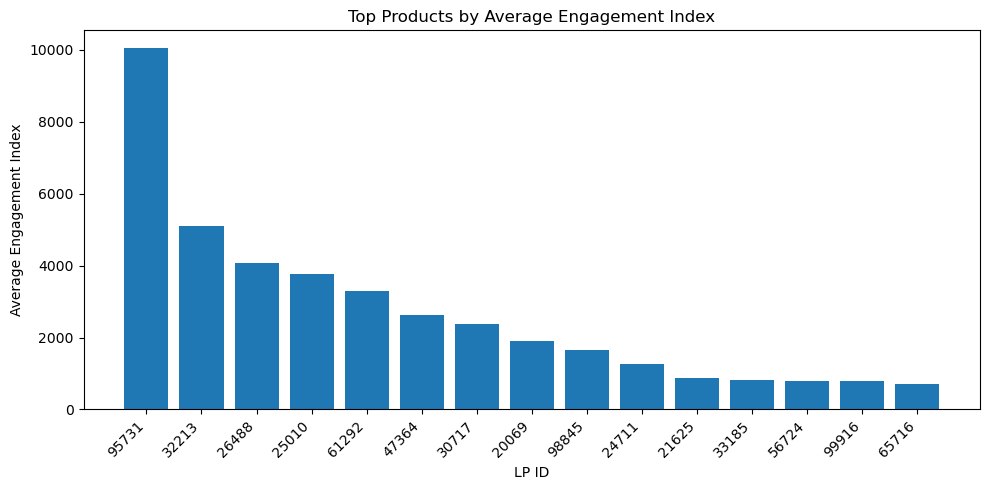

In [10]:
plt.bar(top_products["lp_id"].astype(str), top_products["avg_engagement"])
plt.title("Top Products by Average Engagement Index")
plt.xlabel("LP ID")
plt.ylabel("Average Engagement Index")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [11]:
null_lp = con.execute("""
    SELECT
        COUNT(*) AS total_rows,
        SUM(CASE WHEN lp_id IS NULL THEN 1 ELSE 0 END) AS null_lp_rows
    FROM analytics.fct_daily_engagement;
""").df()

null_lp["pct_null_lp"] = null_lp["null_lp_rows"] / null_lp["total_rows"]
null_lp

,total_rows,null_lp_rows,pct_null_lp
0,1110972,158.0,0.000142


### Data quality note: 
About X% of daily engagement fact rows are missing lp_id. This likely reflects incomplete product mapping in the source LearnPlatform logs. For now, analyses by product filter to rows with non-null lp_id.

In [13]:
volatility = con.execute("""
    SELECT
        lp_id,
        AVG(avg_engagement_index) AS avg_engagement,
        STDDEV_POP(avg_engagement_index) AS engagement_volatility,
        COUNT(*) AS days_observed
    FROM analytics.fct_daily_engagement
    WHERE lp_id IS NOT NULL
    GROUP BY lp_id
    HAVING days_observed >= 30
    ORDER BY engagement_volatility DESC
    LIMIT 10;
""").df()

volatility

,lp_id,avg_engagement,engagement_volatility,days_observed
0,95731,10042.970149,9262.152205,366
1,32213,5110.669611,4678.166308,366
2,25010,3773.760738,4313.840017,325
3,30717,2377.430845,3670.707815,275
4,26488,4061.778756,3473.361230,366
5,47364,2633.153194,2432.497842,366
6,20069,1909.353161,2054.372581,366
7,98845,1652.930951,2012.379712,292
8,61292,3296.521110,1846.499199,199
9,24711,1273.341913,1691.908592,366


### Notes & Analysis

- High volatility products: engagement spikes and drops a lot.
- Low volatility products: stable, consistent usage.